This example will walk through the following:

* **Getting and processing the data.**
* **Defining a model and parameters.**
* **Finding the best parameters,** and some details on why we're using the chosen search algorithm.
* **Scoring** and deploying.

All of these tasks will be performed on the New York City Taxi Cab dataset.

## Setup cluster

In [1]:
import coiled
import dask.distributed

In [ ]:
cluster = coiled.Cluster(
    n_workers=20, 
    configuration="coiled/default", 
)
client = dask.distributed.Client(cluster)

client

## Get and pre-process data

This example will mirror the Kaggle "[NYC Taxi Trip Duration][1]" example with different data.

These data have records on 84 million taxi rides.

[1]:https://www.kaggle.com/c/nyc-taxi-trip-duration/

In [3]:
import dask.dataframe as dd

features = ["passenger_count", "trip_distance", "RatecodeID", "payment_type", "fare_amount"]
output = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]
df = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv", 
    parse_dates=output,
    usecols=features + output,
    dtype={
        "passenger_count": "UInt8",
        "RatecodeID": "UInt8",
        "payment_type": "UInt8",
    },
    blocksize="16 MiB",
)
df = df.persist()

data = df[features]
data = data.fillna(0)

In [33]:
durations = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60  # minutes

In [4]:
len(durations)

84399019

In [25]:
from dask_ml.preprocessing import OneHotEncoder
rates = df["RatecodeID"]

# Difficulty with this command
# rates_flags = OneHotEncoder().fit_transform((rates * 1.0).to_dask_array(lengths=True).reshape(-1, 1))
## After that's done, I'd stick df and rate_flags together and call that the training set
## It might be simpler to skip this cell

In [34]:
from dask_ml.model_selection import train_test_split

features = data.to_dask_array(lengths=True)  # because MLPRegressor doesn't support dataframes
output = durations.to_dask_array(lengths=True)
X_train, X_test, y_train, y_test = train_test_split(features, output, shuffle=True)

# persist the data so it's not re-computed
X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

## Define model and hyperparameters

Let's use Scikit-Learn's neural network as a stand-in for a more complicated model that needs GPUs.

If desired, [PyTorch] can be used seamlessly in Dask-ML through the Scikit-Learn wrapper [skorch]. PyTorch is a popular deep learning that has strong GPU support, and Skorch is a simple wrapper that provides a Scikit-Learn API for PyTorch.

[PyTorch]:https://pytorch.org/
[skorch]:https://skorch.readthedocs.io/en/stable/

In [35]:
from sklearn.neural_network import MLPRegressor
from scipy.stats import uniform, loguniform

# Input: XXX features
# Output: 1 scalar, estimated trip duration
model = MLPRegressor()

params = {
    "hidden_layer_sizes": [
        (100, ),
        (50, ) * 2,
        (34, 33, 33),
        (25, ) * 4,
        (20, ) * 5,
        (10, ) * 10,
    ],  # 100 neurons; how much does width/depth help?
    "activation": ["logistic", "tanh", "relu"],
    "alpha": loguniform(1e-5, 1e-3),
    "batch_size": [128, 256, 512, 1024],
    "learning_rate_init": loguniform(1e-4, 1e-2),
}

All of these parameters control model architecture, execpt for two basic optimizatino parameters, `batch_size` and `learning_rate_init`. They control finding the best model of a particular architecture.

## Find the best hyperparameters

Our search is "computationally-constrained" because (hypothetically) it requires GPUs and has a pretty complicated search space (in reality it has neither of those features). And obviously it's "memory-constrained" because the dataset doesn't fit in memory.

[Dask-ML's documentation on hyperparameter searches][2] indicates that we should use `HyperbandSearchCV`. To use this class, we need to know two items:

* `n_params`, the (approximate) number of parameters to sample.
* `n_examples`, the largest number of examples any model will see.

[2]:https://ml.dask.org/hyper-parameter-search.html

In [39]:
from dask_ml.model_selection import HyperbandSearchCV

n_params = 25
n_examples = 1e6

`HyperbandSearchCV` comes with a rule-of-thumb to computer the inputs:

In [41]:
max_iter = n_params  # how many partial_fit calls?
chunksize = n_examples // n_params  # how many examples does each partial_fit call see?

X_train2 = X_train.rechunk(chunks=(chunksize, -1))
y_train2 = y_train.rechunk(chunks=chunksize)

Now let's run the search. Because this is an initial search, let's set `aggressiveness=4`:


In [42]:
search = HyperbandSearchCV(model, params, max_iter=n_params, aggressiveness=4, random_state=0)

search.fit(X_train2, y_train2, classes=[0, 1]);

KeyboardInterrupt: 

## Score

In [ ]:
search.score(X_test.sample(frac=0.1, random_state=123), y_test.sample(frac=0.1, random_state=123))

We can also obtain the best estimator through the `best_estimator_` attribute:

In [ ]:
search.best_estimator_

This means we can score on the entire dataset:

In [ ]:
from dask_ml.wrappers import ParallelPostFit
deployed_model = ParallelPostFit(search.best_estimator_)
deployed_model.score(X_test, y_test)

`HyperbandSearchCV` and the like mirror the Scikit-Learn model selection interface, so all attributes of Scikit-Learn's [RandomizedSearchCV][rscv] are available:

[rscv]:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [ ]:
search.best_score_

In [ ]:
search.best_params_

## Visualization

What does the error distribution look like?

In [ ]:
y_pred = deployed_model.predict(X_test)

Text(0.5, 1.0, 'Prediction error')

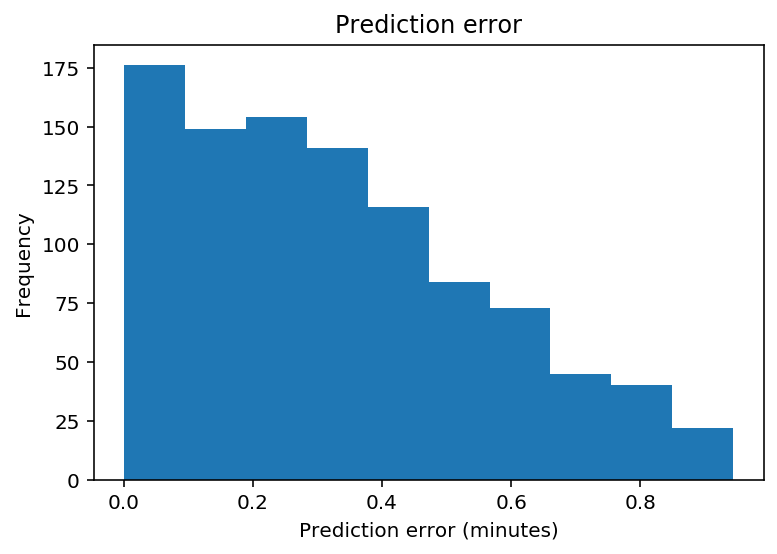

In [7]:
import numpy as np
import pandas as pd

## This cell was run after the fact from a fresh notebook; rerun to 
## y_test := as above. Ground truth trip durations
## y_pred := model output (as in the cell above?)

y_test = np.random.uniform(0, 1, size=1000)
y_pred = np.random.uniform(0, 1, size=1000)

err = np.abs(y_pred - y_test)
ax = pd.Series(err).plot.hist()
ax.set_xlabel("Prediction error (minutes)")
ax.set_title("Prediction error")

## Why not simply sampling instead?

Sampling solves the memory issues:

In [ ]:
X_train_small =  X_train.sample(frac=0.01, random_state=123).compute()
y_train_small = y_train.sample(frac=0.01, random_state=123).compute()

X_train_small  # NumPy ndarray; must fit in memory

But `HyperbandSearchCV` is meant for computationally-constrained problems, regardless of their memory usage (which [Dask-ML's documentation on hyperparameter searches][2] also indicate). `HyperbandSearchCV` would still be relevant:

[2]:https://ml.dask.org/hyper-parameter-search.html

In [ ]:
search = HyperbandSearchCV(model, params, max_iter=81, random_state=0)
search.fit(X_train_small, y_train_small, classes=[0, 1]);

`HyperbandSearchCV` would not be relevant when the search problem is not computationally-constrained, which happens with a smaller search space or a simpler model that doesn't require GPUs.

If we had a simpler model and a massive dataset, `IncrementalSearchCV` is recommended. It mirrors Scikit-Learn's `RandomizedSearchCV` but works on Dask Arrays/Dataframes, both of which can be larger than memory.